# DINO with memory brank from Hummingbird (inference only)

In [1]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d residentmario/ade20k-outdoors

 97% 194M/200M [00:02<00:00, 109MB/s]
100% 200M/200M [00:02<00:00, 89.3MB/s]


In [5]:
!unzip -q /content/ade20k-outdoors.zip

In [3]:
!pip install transformers
!pip install datasets
!pip install tqdm
!pip install scann

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 53.6 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled k

In [4]:
import torch
import scann
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
from datasets import load_dataset
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import random_split

# Preprocessing

In [6]:
from transformers import ViTImageProcessor, ViTModel
processor = ViTImageProcessor.from_pretrained('facebook/dino-vitb16')
model = ViTModel.from_pretrained('facebook/dino-vitb16')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.images = os.listdir(image_dir)




    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace('.jpg', '.png'))
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)  # convert mask to grayscale
        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        image = image.permute(1, 2, 0)

        return image, np.array(mask)
# Define a custom transform function
def clamp_image(img):
    return torch.clamp(img, 0, 1)

# Define transformations for images
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    clamp_image  # Clamp only for images
])

# Define transformations for masks (without clamping)
mask_transform = transforms.Compose([
    transforms.Resize((224, 224))  # No clamping for masks
])

dataset = SegmentationDataset(image_dir='/content/images/training', mask_dir='/content/annotations/training', image_transform=image_transform, mask_transform=mask_transform)

In [8]:
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
test_size = dataset_size - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for each dataset
# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [9]:
from torch.utils.data import Subset, DataLoader

# Define the size of the subset
subset_size = 500

# Create a subset of the original dataset
subset_indices = torch.randperm(len(train_dataset))[:subset_size]
subset = Subset(train_dataset, subset_indices)

# Create a DataLoader from this subset
subset_loader = DataLoader(subset, batch_size=4, shuffle=True)

In [10]:
subset_size = 10

# Create a subset of the original dataset
subset_indices = torch.randperm(len(test_dataset))[:subset_size]
subset = Subset(test_dataset, subset_indices)

# Create a DataLoader from this subset
subset_loader_test = DataLoader(subset, batch_size=1, shuffle=False)

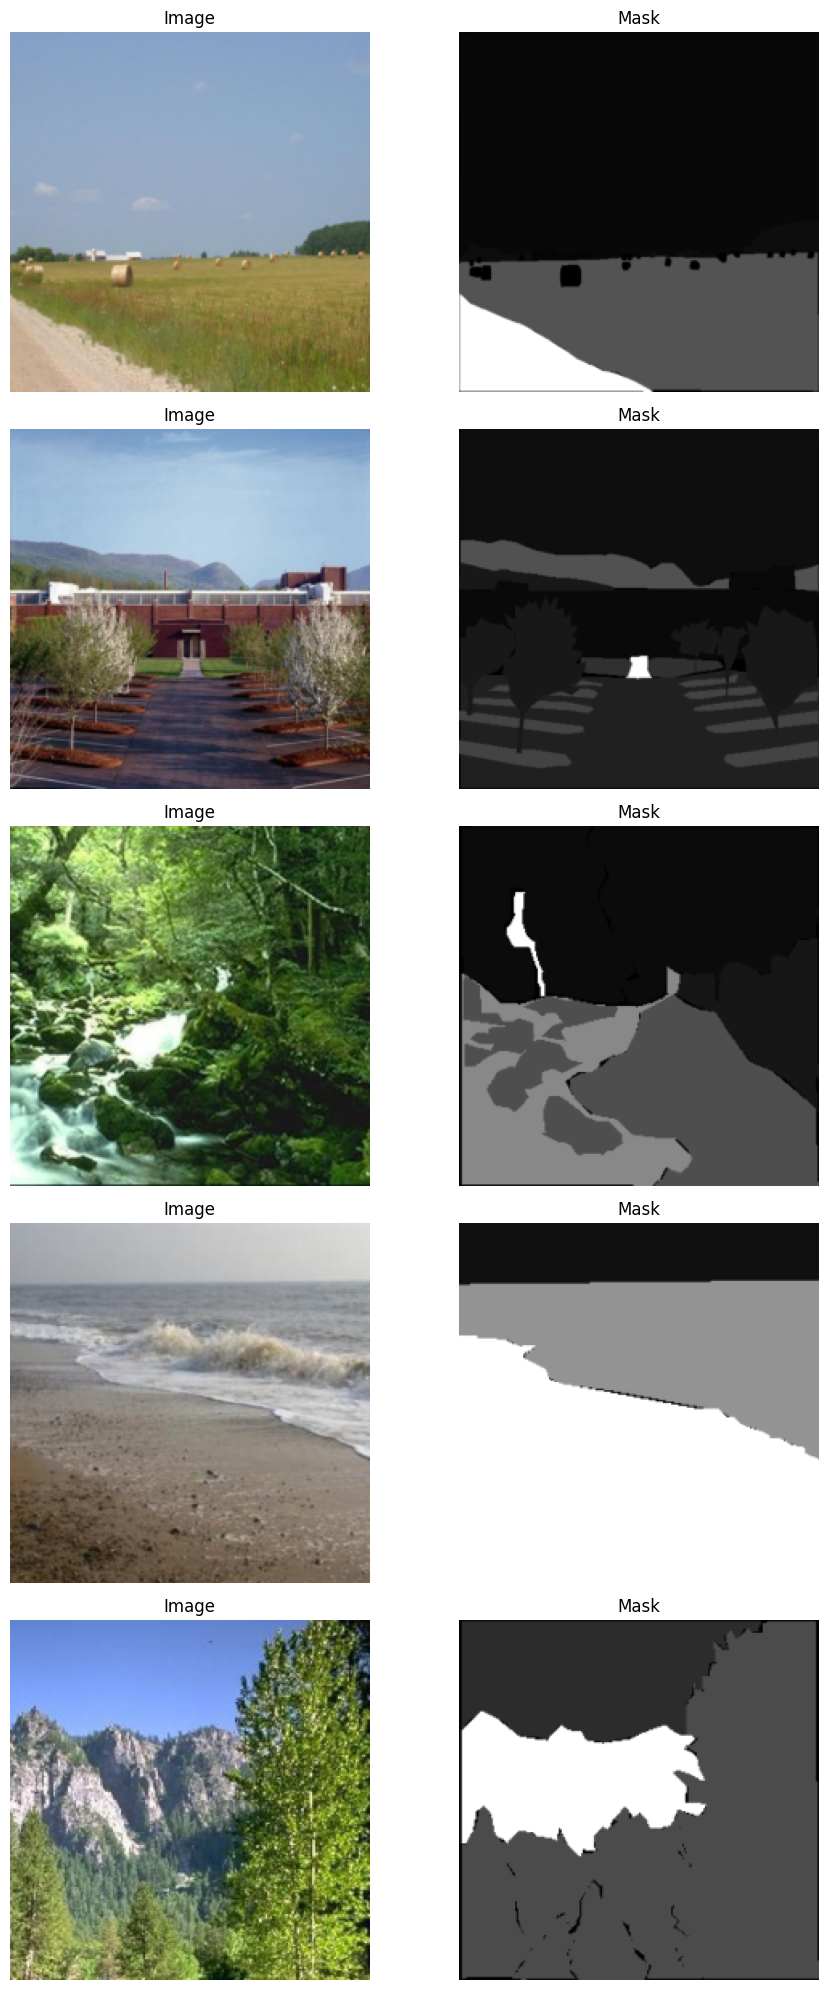

In [11]:
fig, ax = plt.subplots(5, 2, figsize=(10, 20))

for i in range(5):
    image, mask = train_dataset[i]


    ax[i, 0].imshow(image.numpy())
    ax[i, 1].imshow(mask, cmap='gray')

    ax[i, 0].set_title('Image')
    ax[i, 1].set_title('Mask')

    ax[i, 0].axis('off')
    ax[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [65]:
# Assume `segmentation_map` is a numpy array of shape (224, 224) with semantic segmentation labels
# Each unique value in the segmentation_map represents a different class

# Function to divide the image into patches and average the labels within each patch
def average_labels(segmentation_map, patch_size=(16, 16)):
    # Get the shape of the segmentation map
    batch_size,h,w = segmentation_map.shape
    # Calculate the number of patches along each dimension
    h_patches = h // patch_size[0]
    w_patches = w // patch_size[1]

    batch_patch_labels = []
    # Loop over each image in the batch
    for b in range(batch_size):
        # Initialize a list to hold the average label for each patch for the current image
        patch_labels = []

        # Loop over the segmentation map and compute the average label for each patch
        for i in range(h_patches):
            for j in range(w_patches):
                # Define the patch boundaries
                start_i = i * patch_size[0]
                start_j = j * patch_size[1]
                end_i = start_i + patch_size[0]
                end_j = start_j + patch_size[1]

                # Extract the patch
                patch = segmentation_map[b, start_i:end_i, start_j:end_j].to(torch.float16)


                # Compute the most frequent label (mode) within the patch
                # labels, counts = np.unique(patch, return_counts=True)
                # most_frequent_label = labels[np.argmax(counts)]

                #Compute the mean label within the patch
                average_label = torch.mean(patch)
                # average_label = np.round(average_label).to(torch.uint8)
                # Append the most frequent label to the list for the current image
                patch_labels.append(average_label)

        # Append the list of patch labels for the current image to the batch list

        batch_patch_labels.append(patch_labels)
    return np.array(batch_patch_labels)



# Populating memory bank

In [13]:
memory_bank = []
model = model.to(device)
# Process each image in the image list
for image, label in tqdm(subset_loader, desc="Populate memory bank"):
    # Process the image and label
    local_labels = average_labels(label)
    inputs = processor(images=image, return_tensors="pt")
    inputs = inputs.to(device)
    # Extract features using the model
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state


    # For ViT, the [CLS] token is at the first position (index 0) in the sequence
    patch_features = last_hidden_states[:,1:, :]

    # L2-normalize the feature vector
    patch_features = features = torch.nn.functional.normalize(patch_features, p=2, dim=-1)
    for i in range(patch_features.size(0)):  # Iterate over batch
        # Get the features and labels for the i-th item in the batch
        patch_features = patch_features.cpu()
        features = patch_features[i]
        labels = local_labels[i]

        # Extend the memory bank with the features and labels
        # Here we convert them to CPU tensors and detach from the graph
        memory_bank.append((features.detach(), labels))

Populate memory bank: 100%|██████████| 125/125 [00:24<00:00,  5.04it/s]


In [14]:
keys = np.array([tup[0].numpy() for tup in memory_bank]) # (number of samples * number of patches) * dim size
labels = np.array([tup[1] for tup in memory_bank])

keys = keys.reshape(-1,keys.shape[2])
labels = labels.reshape(-1)

In [15]:
del model
del processor
del inputs
del memory_bank
torch.cuda.empty_cache()
import gc
# Run garbage collection
gc.collect()

885

In [16]:
processor = ViTImageProcessor.from_pretrained('facebook/dino-vitb16')
model = ViTModel.from_pretrained('facebook/dino-vitb16')

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Retrieving from memory bank and prediction

In [17]:
searcher = scann.scann_ops_pybind.builder(keys, 90, "dot_product").tree(
    num_leaves=512, num_leaves_to_search=256, training_sample_size=250000).score_ah(
    4, anisotropic_quantization_threshold=0.2).reorder(1800).build()

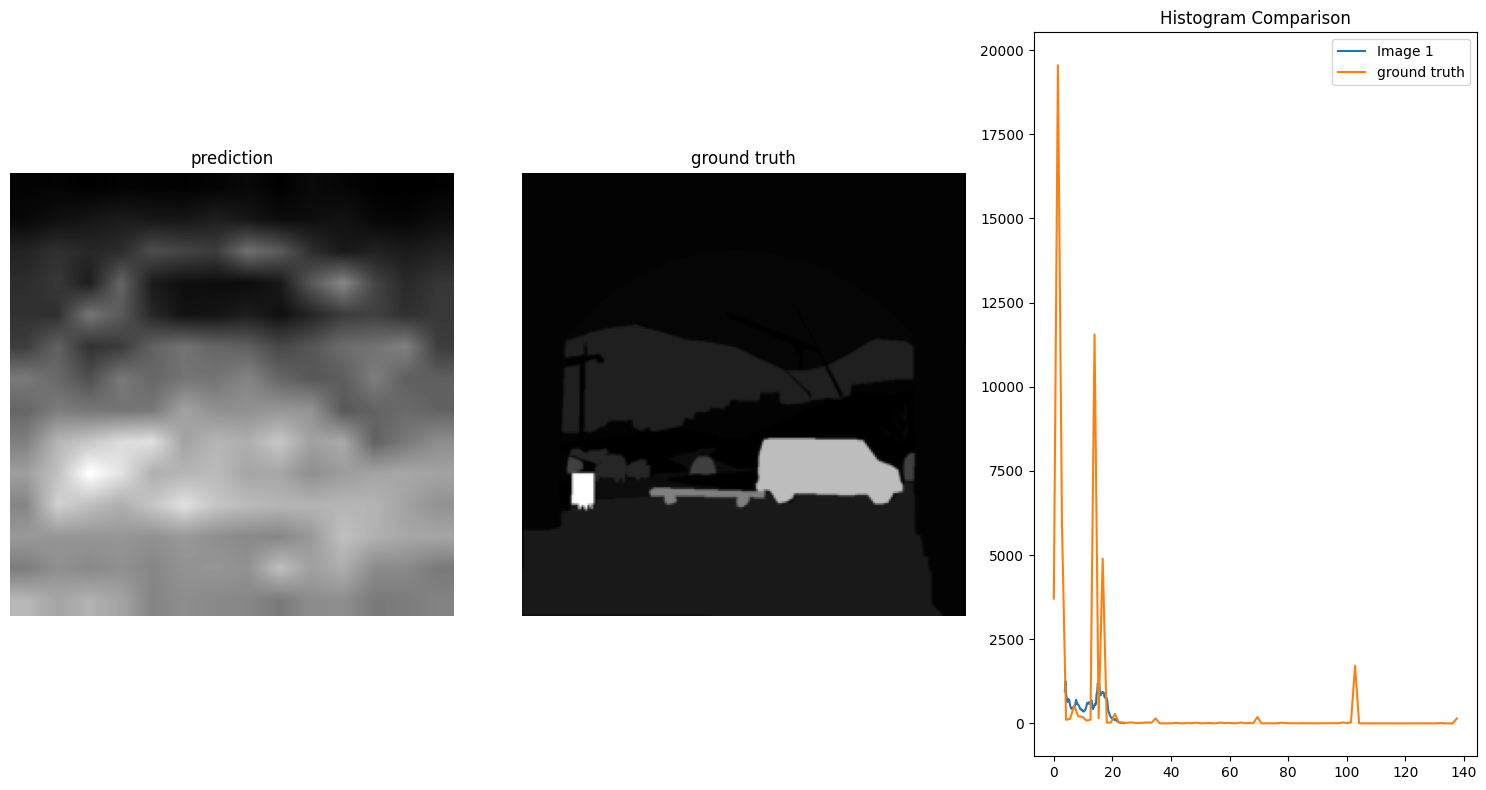

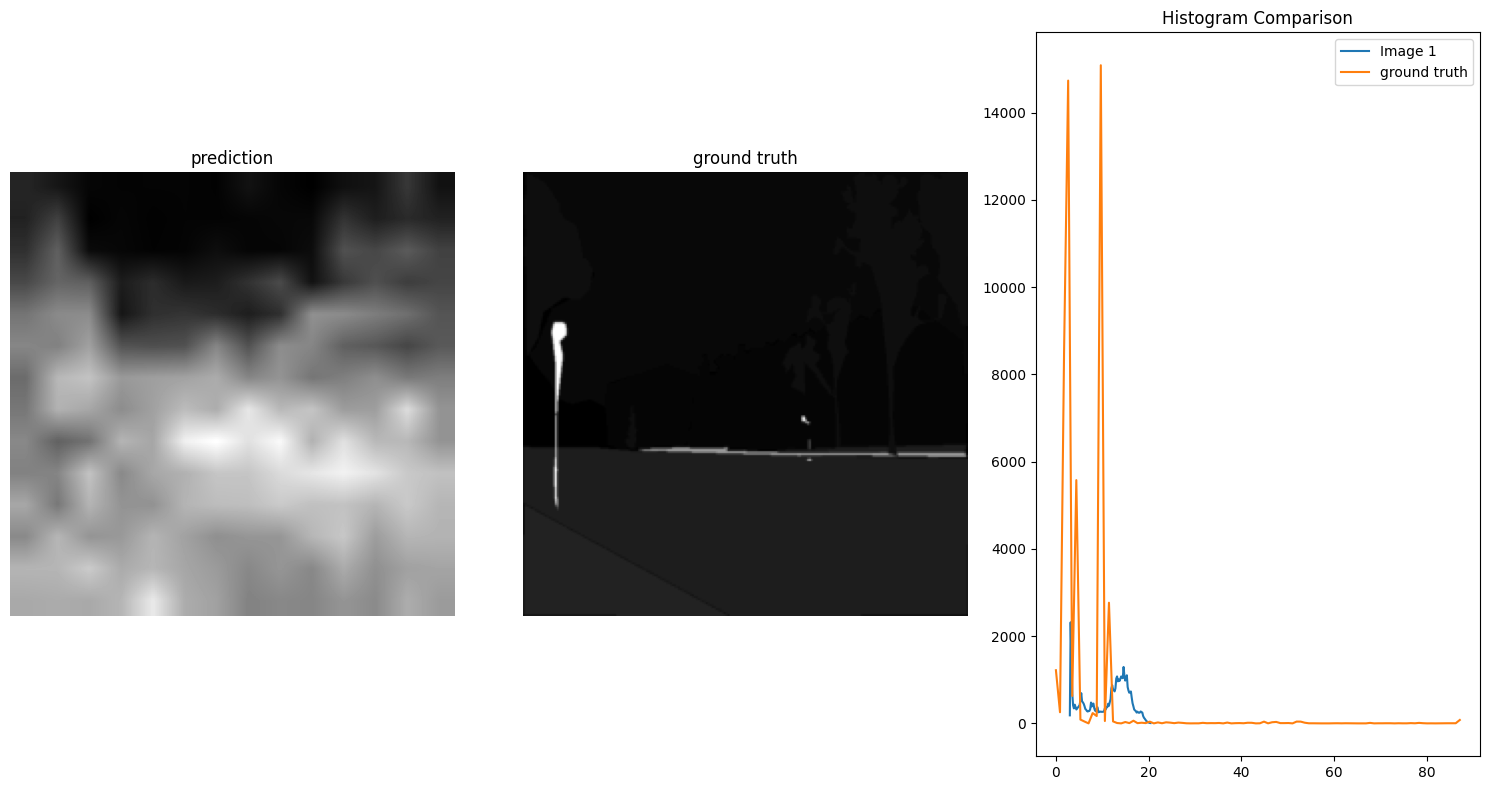

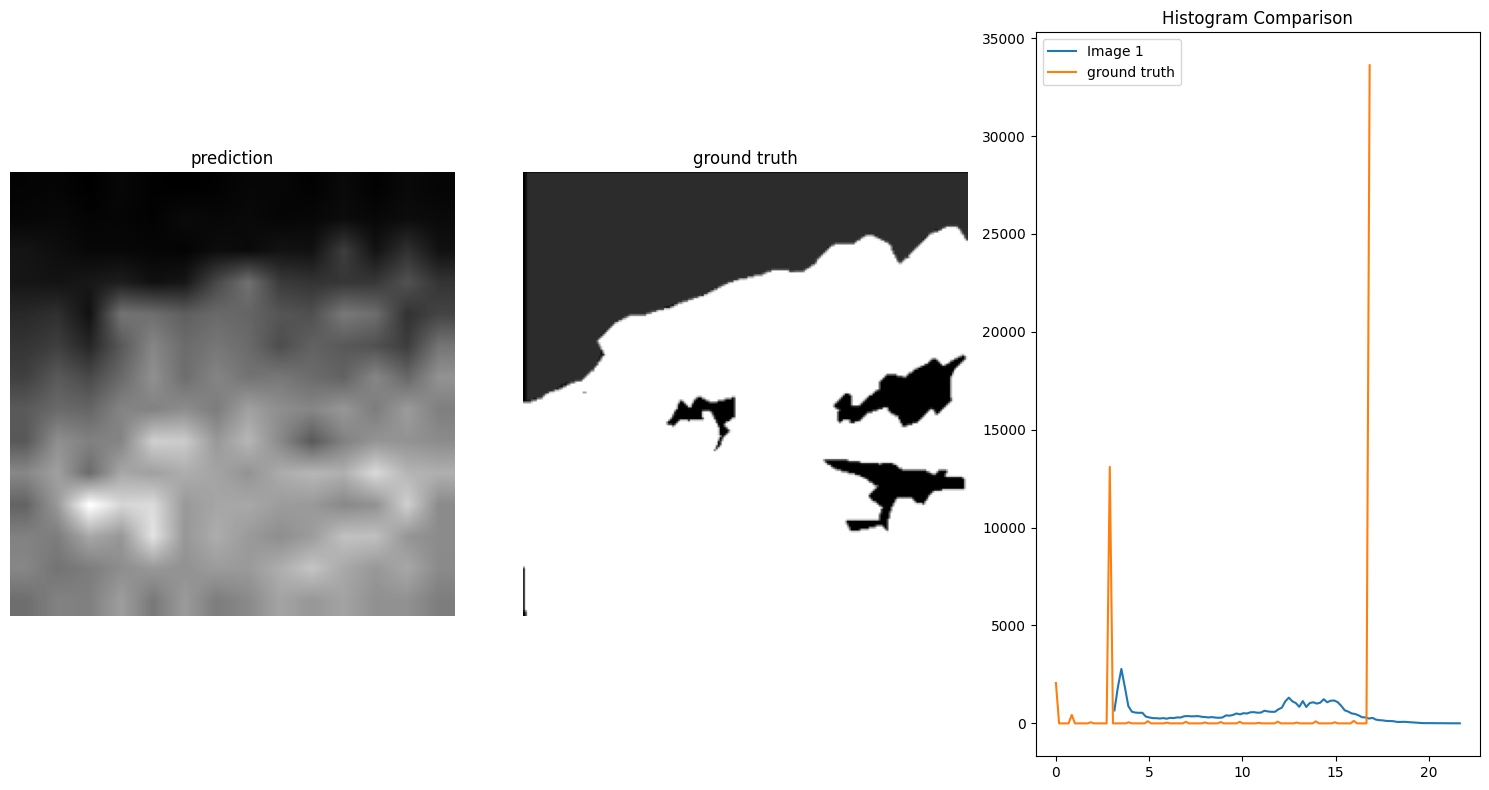

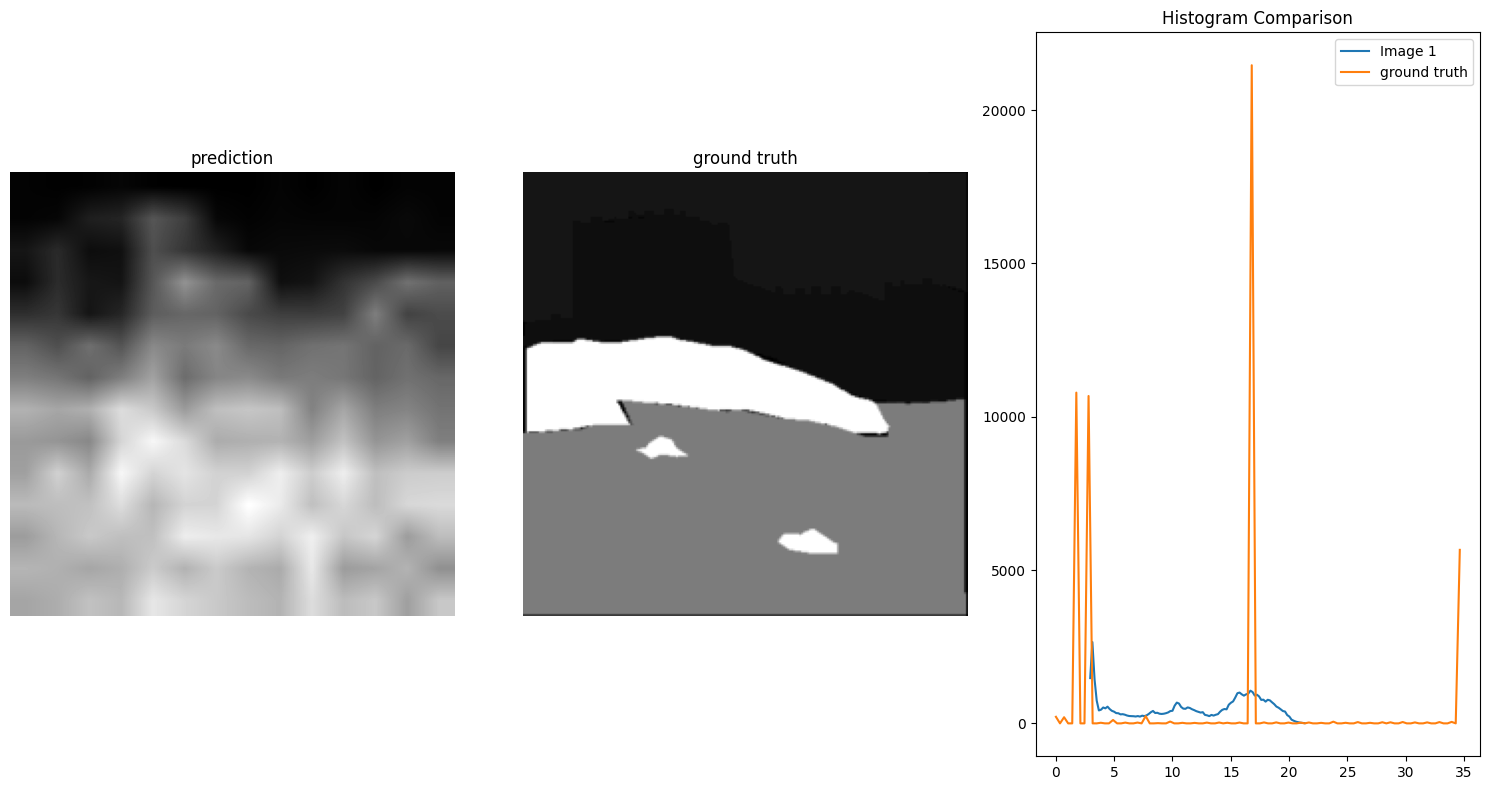

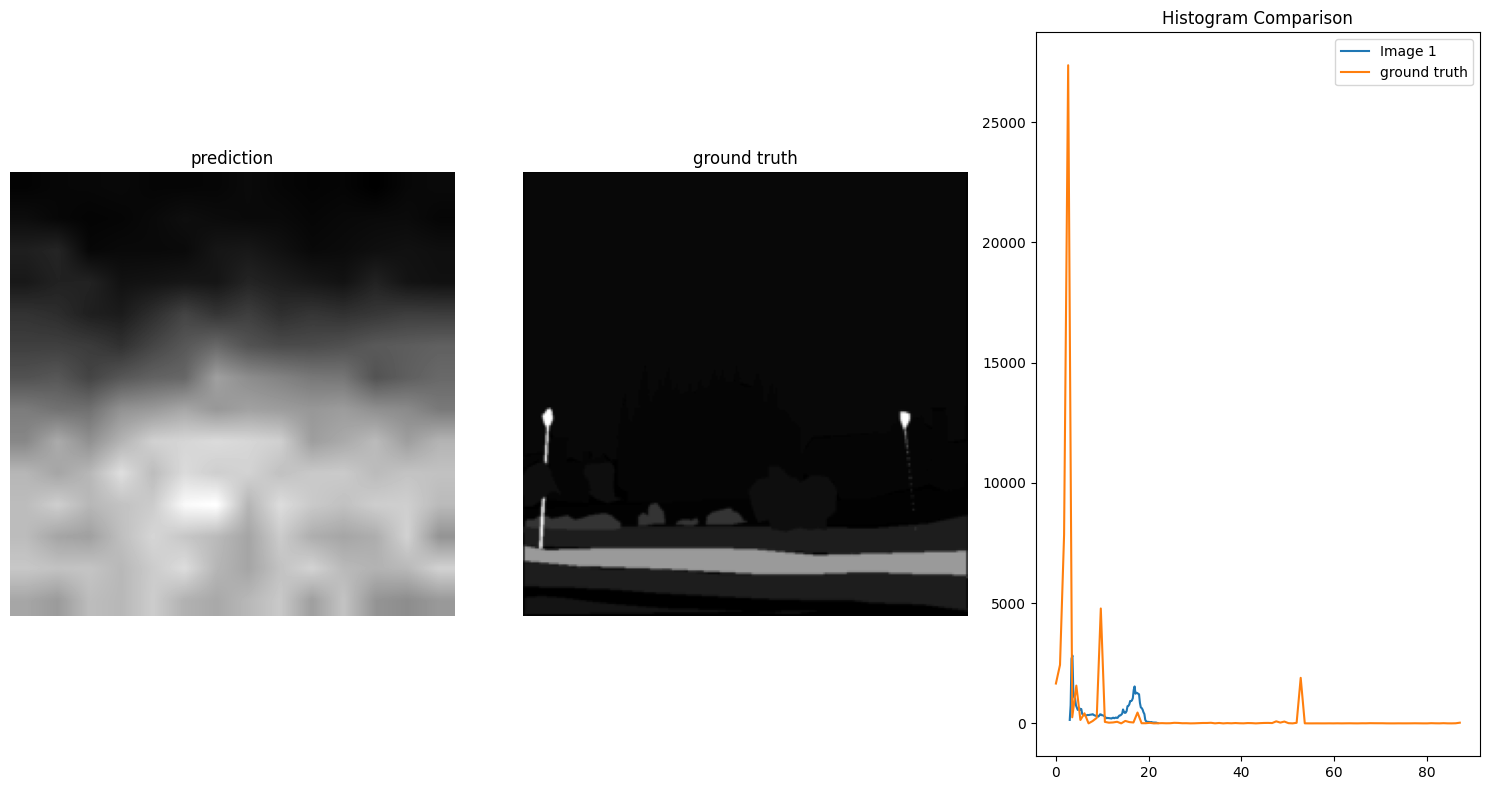

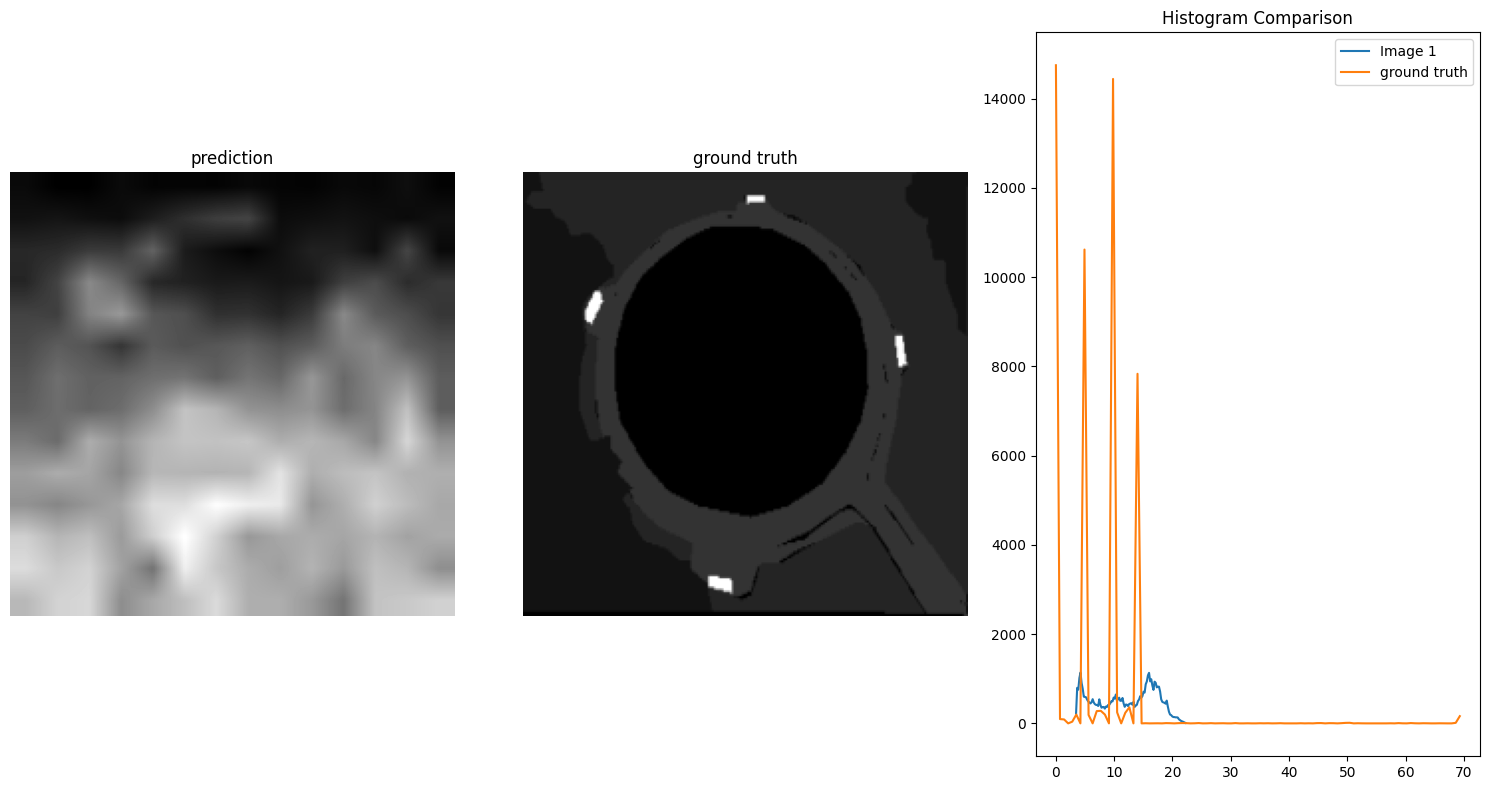

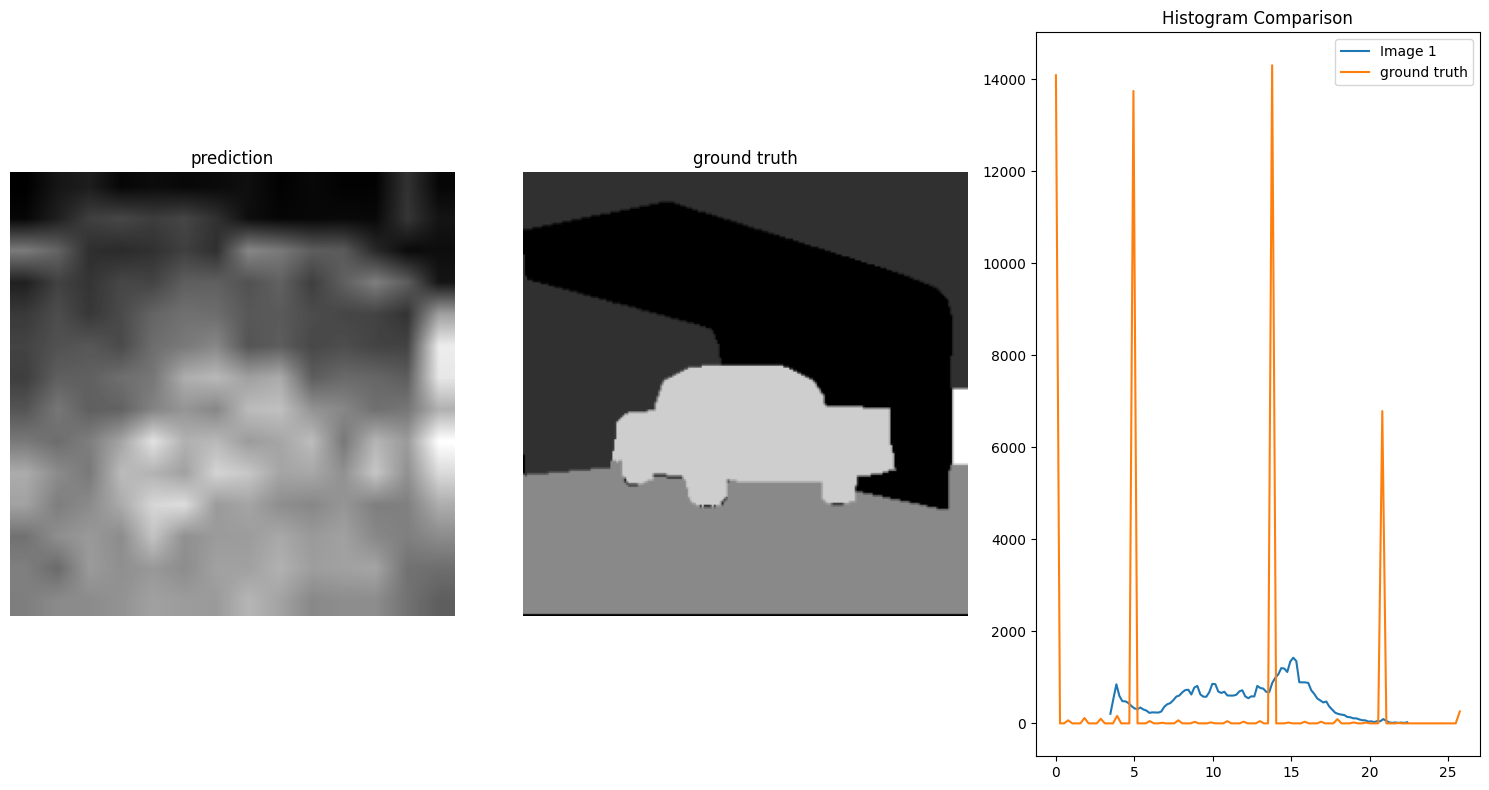

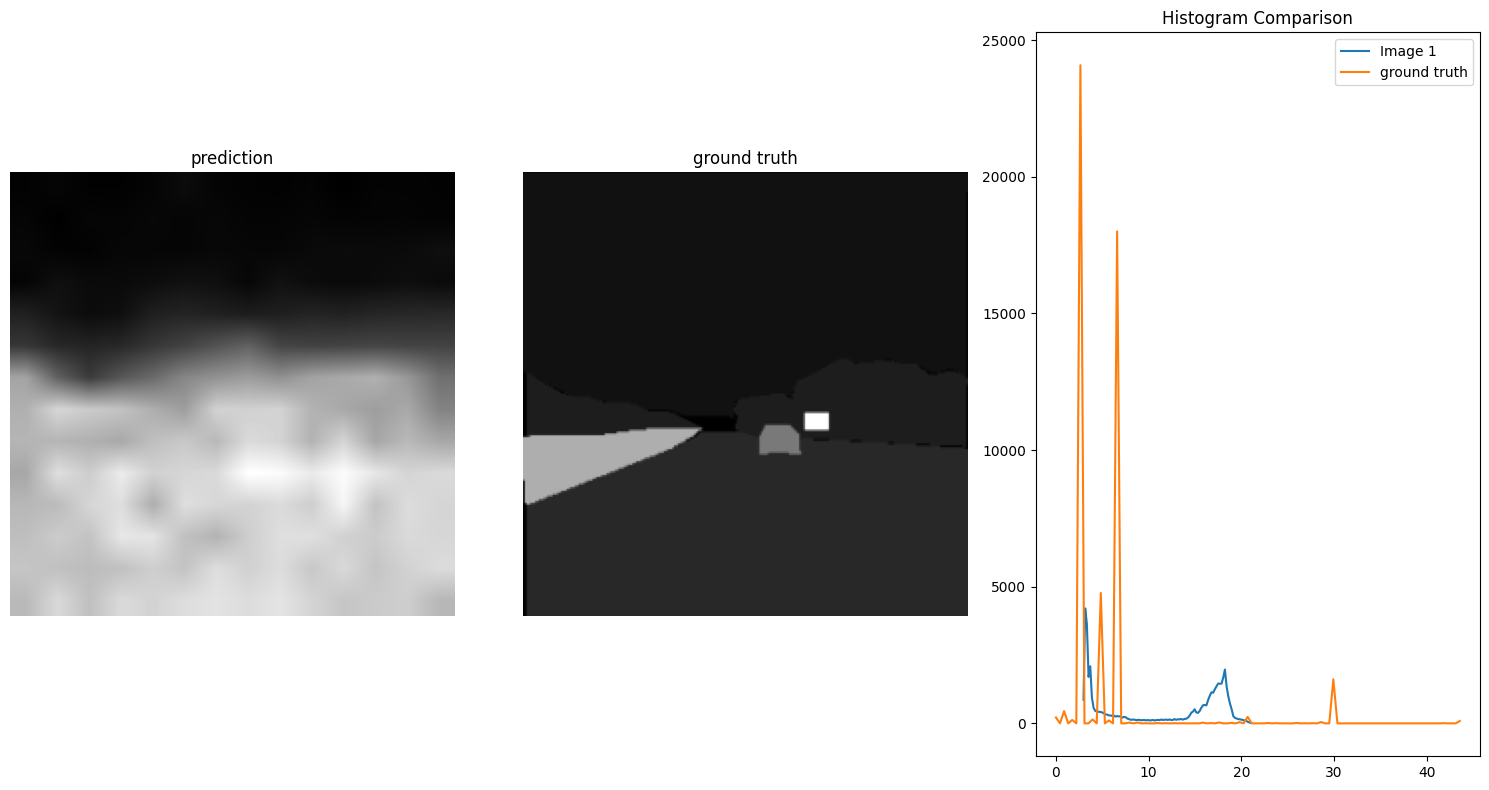

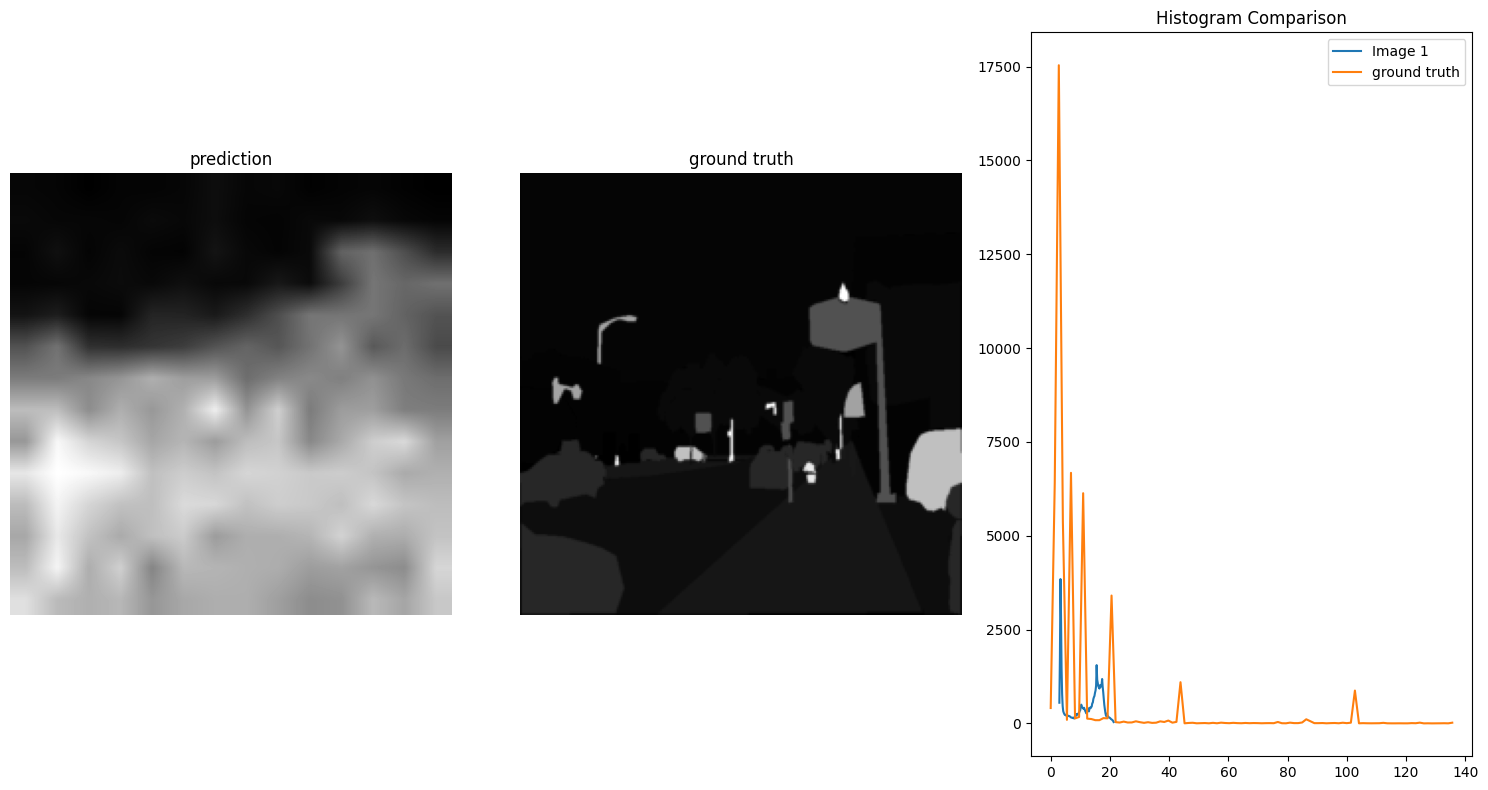

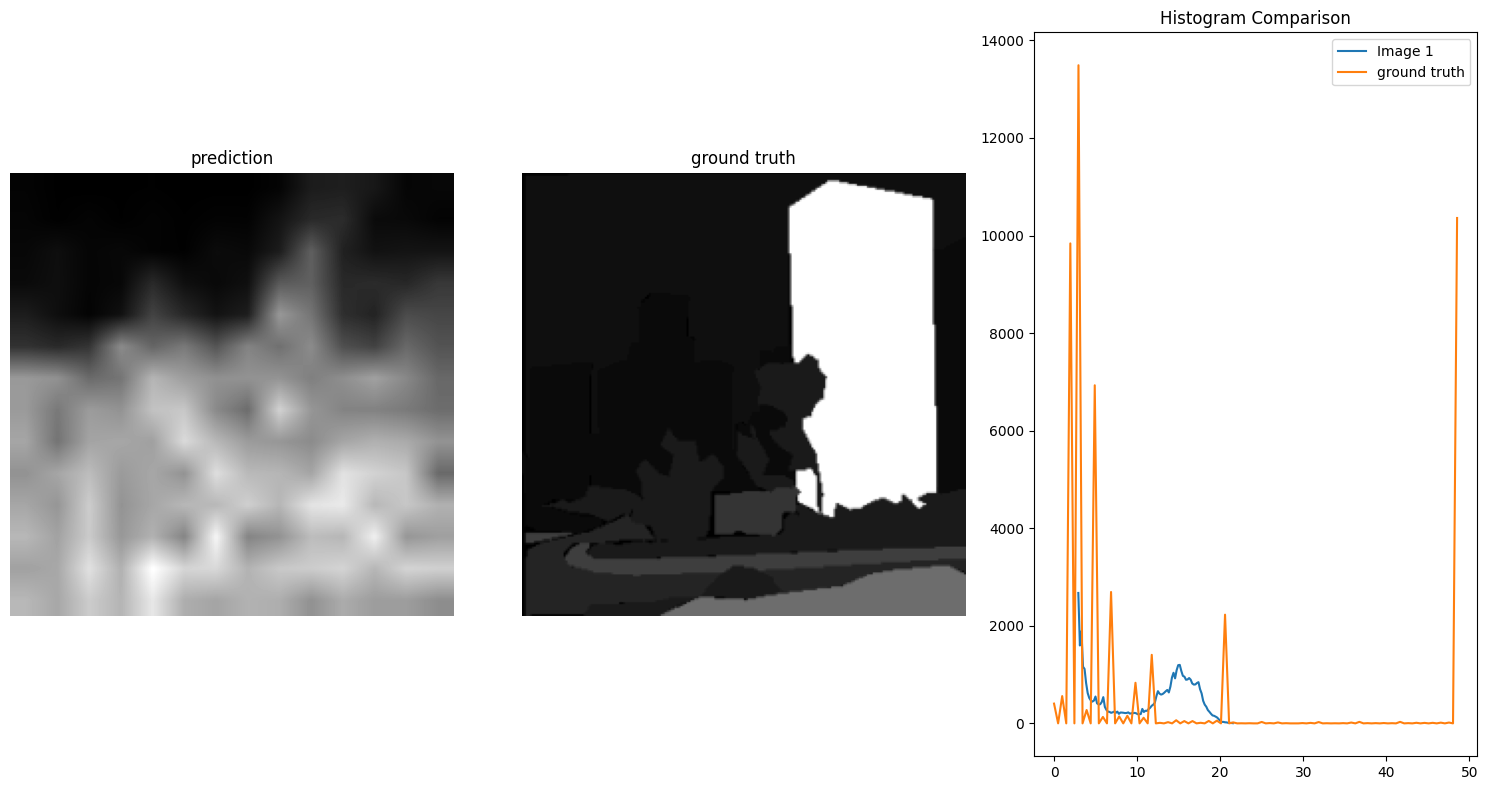

In [19]:
beta = .1

for image, label in subset_loader_test:
    # Process the image and label
    inputs = processor(images=image, return_tensors="pt")
    inputs = inputs.to(device)
    # Extract features using the model
    model.to(device)
    model.eval()
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    #Squeeze the batch dimension out
    last_hidden_states = last_hidden_states.squeeze(0)
    # For ViT, the [CLS] token is at the first position (index 0) in the sequence
    patch_features = last_hidden_states[1:, :]
    #patch features [784 x 768] keys
    patch_features = torch.nn.functional.normalize(patch_features, p=2, dim=-1)
    # Perform the search. This will return the indices of the top-k nearest neighbors.
    neighbors, similarity = searcher.search_batched(patch_features.cpu().detach())

    similarity = (1/beta)*similarity
    similarity = torch.tensor(similarity)
    similarity  = F.softmax(similarity, dim=1)


    neighbor_labels = labels[neighbors]

    weighted_labels = similarity * neighbor_labels.astype(np.float32)
    local_predictions = torch.sum(weighted_labels, dim=1)
    # print(local_predictions.int())
    # print(label[0])

    local_predictions_reshaped = local_predictions.reshape((14,14))
    # print(local_predictions_reshaped)
    # Upsample the downsampled predictions to the original image size
    predictions_image = Image.fromarray(np.array(local_predictions_reshaped))#.astype(np.int16))
    pred = predictions_image.resize((224, 224), Image.BILINEAR)
    pred = np.array(pred)
    hist1, bins1 = np.histogram(pred.flatten(), bins=100)
    hist2, bins2 = np.histogram(label.flatten(), bins=100)

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(15, 8))
    # Display images
    axes[0].imshow(pred, cmap='gray')
    axes[0].set_title('prediction')
    axes[0].axis('off')

    axes[1].imshow(label.squeeze(), cmap='gray')
    axes[1].set_title('ground truth')
    axes[1].axis('off')

    # Display histograms
    axes[2].plot(bins1[:-1], hist1, label='Image 1')
    axes[2].plot(bins2[:-1], hist2, label='ground truth')
    axes[2].set_title('Histogram Comparison')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

# ISSUES

Problems I am seeing currently is that averaging the labels in patch for the memory bank, results in blurry and very uniform looking masks. This is likely due to the fact that all labels are averages per patch so the retrieval system also is only able to get average label values resulting in mostly grey segmentation maps.

If I change the average label to most frequent label (in the patch). I am getting very erratic and chaotic segmentation maps. With sometimes a patch containing a vastly different label compared to the neighbours and shapes (or coherent regions of similar labels) are non-existent.

- This is either a result of incorrect implementation of the attention mechanism,
- or because the limited prompt images used (500 images of in similar domain).
- Additionally, it could be the scaNN setup, but I use the same settings as the original authors.

The shapes of the segmentation maps however do match the ground truth. Especially background label (for things like sky), this could indicate that the nearest neighbour search for those features seem to work as expected.

# TODO

- Try to do depth estimation
- Improve performance on ADE20k subset...

In [21]:
!kaggle datasets download -d soumikrakshit/nyu-depth-v2

100% 4.10G/4.10G [00:43<00:00, 116MB/s] 
100% 4.10G/4.10G [00:43<00:00, 101MB/s]


In [22]:
!unzip -q /content/nyu-depth-v2.zip

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.images = os.listdir(image_dir)




    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace('.jpg', '.png'))
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)  # convert mask to grayscale
        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        image = image.permute(1, 2, 0)

        return image, np.array(mask)
# Define a custom transform function
def clamp_image(img):
    return torch.clamp(img, 0, 1)

# Define transformations for images
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    clamp_image  # Clamp only for images
])

# Define transformations for masks (without clamping)
mask_transform = transforms.Compose([
    transforms.Resize((224, 224))  # No clamping for masks
])


In [58]:
import pandas as pd

import os
from PIL import Image
from torch.utils.data import Dataset

class NYUDepthV2Dataset(Dataset):
    def __init__(self, root_dir, image_transform=None, mask_transform=None):
        """
        Args:
            root_dir (string): Root directory with all the subdirectories of images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.image_pairs = self._get_image_pairs()

    def _get_image_pairs(self):
        pairs = []
        for subdir, _, files in os.walk(self.root_dir):
            images = {}
            for file in files:
                if file.endswith('.jpg') or file.endswith('.png'):
                    number = os.path.splitext(file)[0]
                    images.setdefault(number, []).append(file)

            for number, file_list in images.items():
                if len(file_list) == 2:
                    color_image = [f for f in file_list if f.endswith('.jpg')]
                    depth_image = [f for f in file_list if f.endswith('.png')]
                    if color_image and depth_image:
                        pairs.append((os.path.join(subdir, color_image[0]), os.path.join(subdir, depth_image[0])))
        return pairs

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        color_path, depth_path = self.image_pairs[idx]

        color_image = Image.open(color_path)
        depth_image = Image.open(depth_path)

        if self.image_transform:
            color_image = self.image_transform(color_image)
        if self.mask_transform:
            depth_image = self.mask_transform(depth_image)
        color_image = color_image.permute(1, 2, 0)
        depth_image = depth_image.permute(1, 2, 0)
        return color_image, depth_image


# Define transformations for images
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # clamp_image  # Clamp only for images
])

# Define transformations for masks (without clamping)
mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # No clamping for masks
    transforms.ToTensor(),
])

# Example usage
train_dataset = NYUDepthV2Dataset( root_dir='/content/nyu_data/data/nyu2_train', image_transform=image_transform, mask_transform=mask_transform)



In [109]:
import os
from PIL import Image
from torch.utils.data import Dataset

class NYUDepthV2Dataset_test(Dataset):
    def __init__(self, root_dir, csv_file, image_transform=None, mask_transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.dataframe = pd.read_csv(csv_file)
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        # Assuming you know the total number of images or can calculate it
        # Replace 10000 with the actual number of images you have
        return len(self.dataframe)

    def __getitem__(self, idx):
        idx= idx.item()
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        depth_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 1])

        image = Image.open(img_name)
        mask = Image.open(depth_name)

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        image = image.permute(1, 2, 0)
        mask = mask.permute(1, 2, 0)
        return image, mask

# Define transformations for images
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # clamp_image  # Clamp only for images
])

# Define transformations for masks (without clamping)
mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # No clamping for masks
    transforms.ToTensor(),
])
test_dataset = NYUDepthV2Dataset_test(root_dir='/content/nyu_data/', csv_file = "/content/nyu_data/data/nyu2_test.csv", image_transform = image_transform, mask_transform = mask_transform)


In [110]:
# Define the size of the subset
subset_size_train = 500

# Create a subset of the original dataset
subset_indices = torch.randperm(len(train_dataset))[:subset_size_train]
subset_train = Subset(train_dataset, subset_indices)

# Create a DataLoader from this subset
subset_loader_train = DataLoader(subset_train, batch_size=4, shuffle=True)

subset_size_test = 10

# Create a subset of the original dataset
subset_indices = torch.randperm(len(test_dataset))[:subset_size_test]
subset_test = Subset(test_dataset, subset_indices)

# Create a DataLoader from this subset
subset_loader_test = DataLoader(subset_test, batch_size=1, shuffle=False)

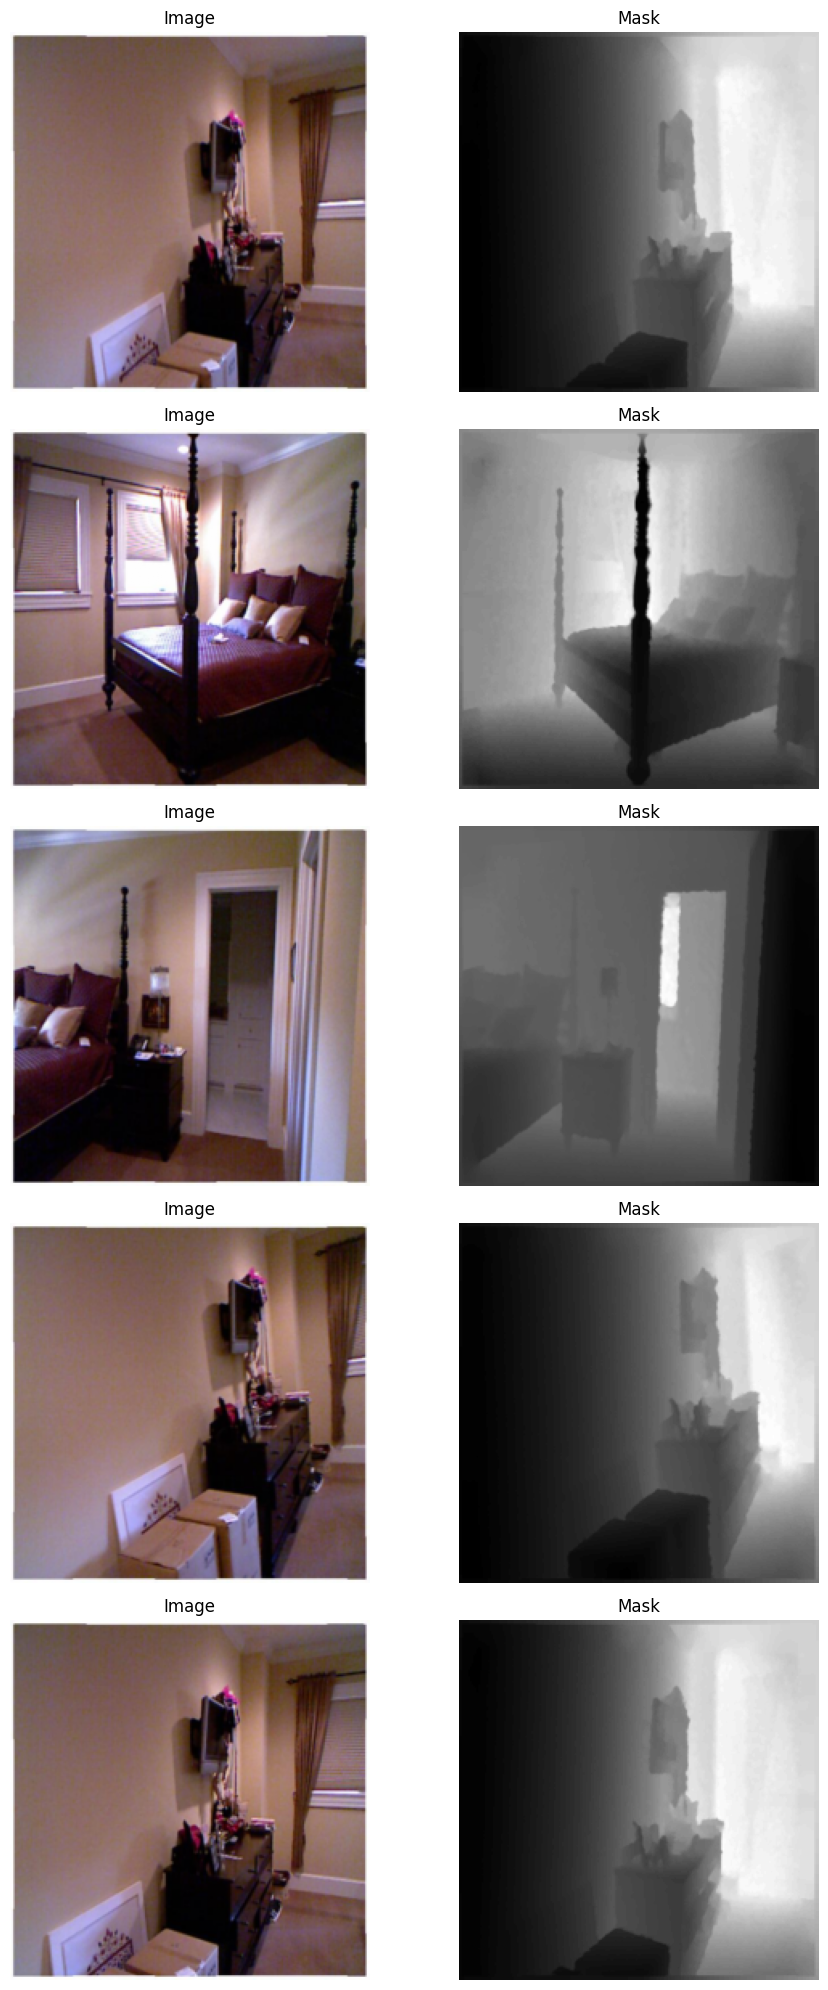

In [60]:
fig, ax = plt.subplots(5, 2, figsize=(10, 20))

for i in range(5):
    image, mask = train_dataset[i]
    ax[i, 0].imshow(image)
    ax[i, 1].imshow(mask, cmap='gray')

    ax[i, 0].set_title('Image')
    ax[i, 1].set_title('Mask')

    ax[i, 0].axis('off')
    ax[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [66]:
memory_bank = []
model = model.to(device)
# Process each image in the image list
for image, label in tqdm(subset_loader_train, desc="Populate memory bank"):
    # Process the image and label
    local_labels = average_labels(label.squeeze())
    inputs = processor(images=image, return_tensors="pt")
    inputs = inputs.to(device)
    # Extract features using the model
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state


    # For ViT, the [CLS] token is at the first position (index 0) in the sequence
    patch_features = last_hidden_states[:,1:, :]

    # L2-normalize the feature vector
    patch_features = features = torch.nn.functional.normalize(patch_features, p=2, dim=-1)
    for i in range(patch_features.size(0)):  # Iterate over batch
        # Get the features and labels for the i-th item in the batch
        patch_features = patch_features.cpu()
        features = patch_features[i]
        labels = local_labels[i]

        # Extend the memory bank with the features and labels
        # Here we convert them to CPU tensors and detach from the graph
        memory_bank.append((features.detach(), labels))

Populate memory bank: 100%|██████████| 125/125 [00:20<00:00,  6.15it/s]


In [67]:
keys = np.array([tup[0].numpy() for tup in memory_bank]) # (number of samples * number of patches) * dim size
labels = np.array([tup[1] for tup in memory_bank])

keys = keys.reshape(-1,keys.shape[2])
labels = labels.reshape(-1)

In [68]:
del model
del processor
del inputs
del memory_bank
torch.cuda.empty_cache()
import gc
# Run garbage collection
gc.collect()

83523

In [69]:
processor = ViTImageProcessor.from_pretrained('facebook/dino-vitb16')
model = ViTModel.from_pretrained('facebook/dino-vitb16')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [70]:
searcher = scann.scann_ops_pybind.builder(keys, 90, "dot_product").tree(
    num_leaves=512, num_leaves_to_search=256, training_sample_size=250000).score_ah(
    4, anisotropic_quantization_threshold=0.2).reorder(1800).build()

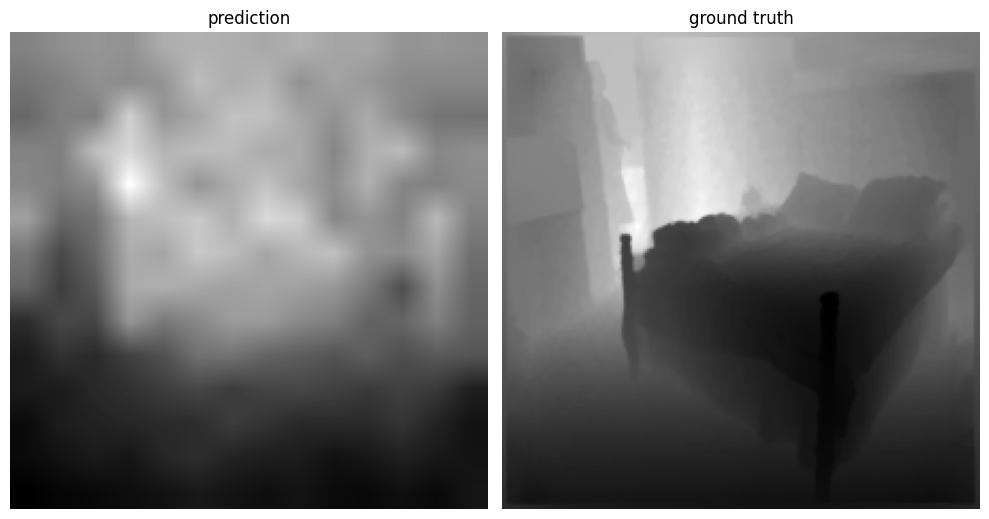

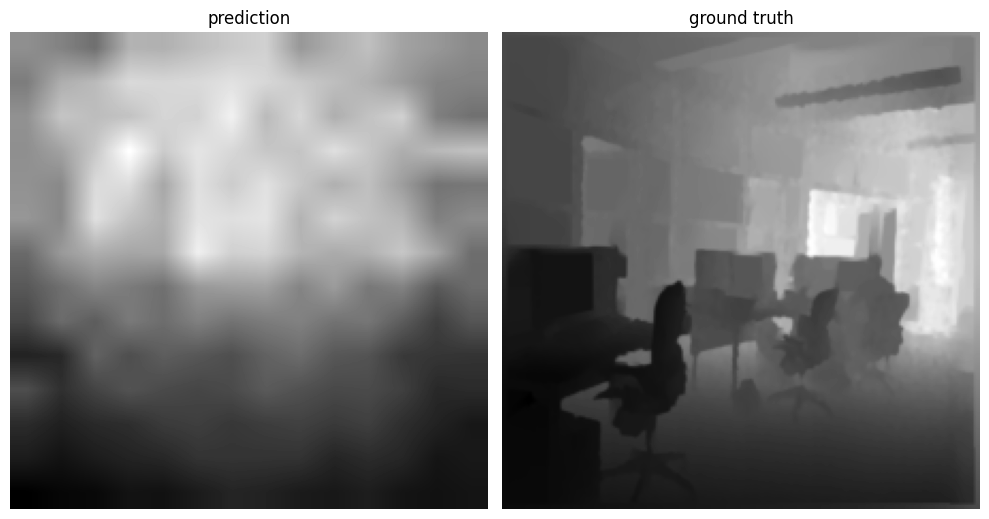

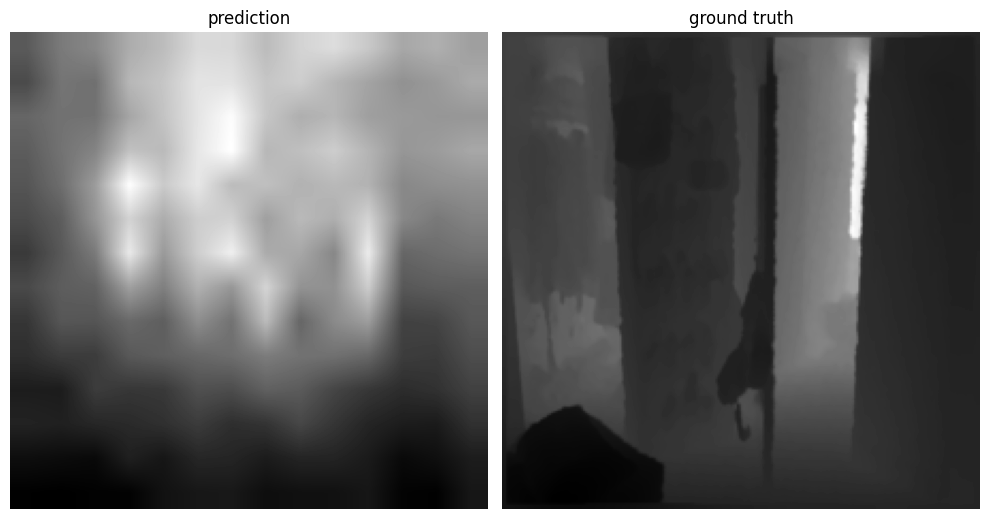

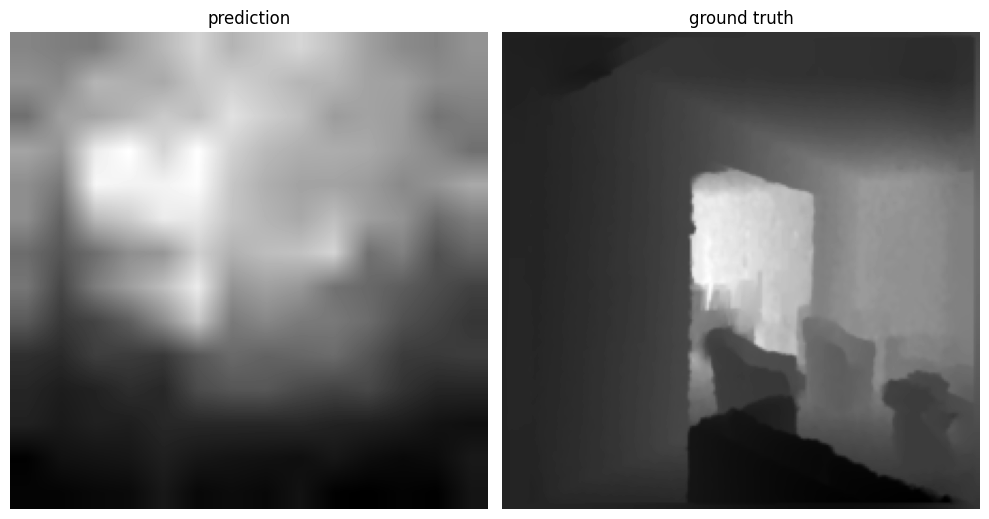

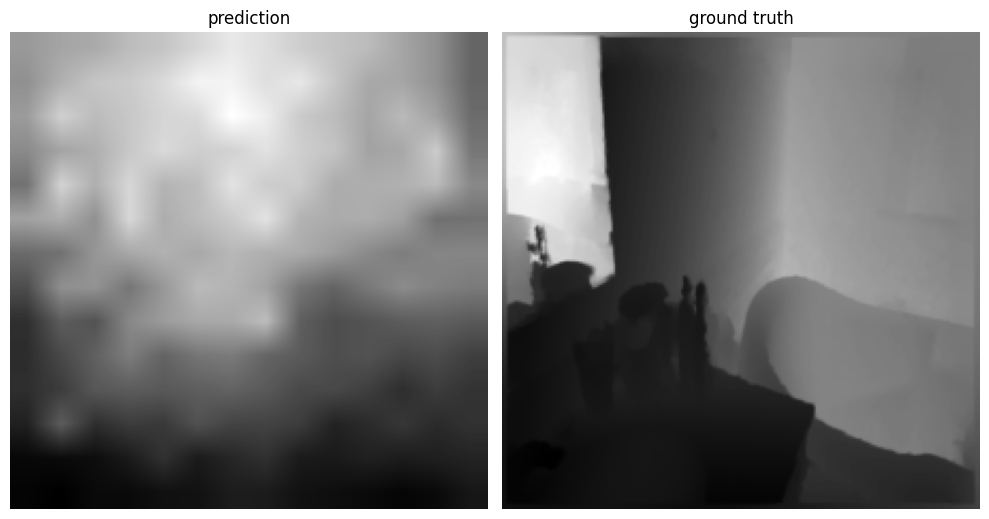

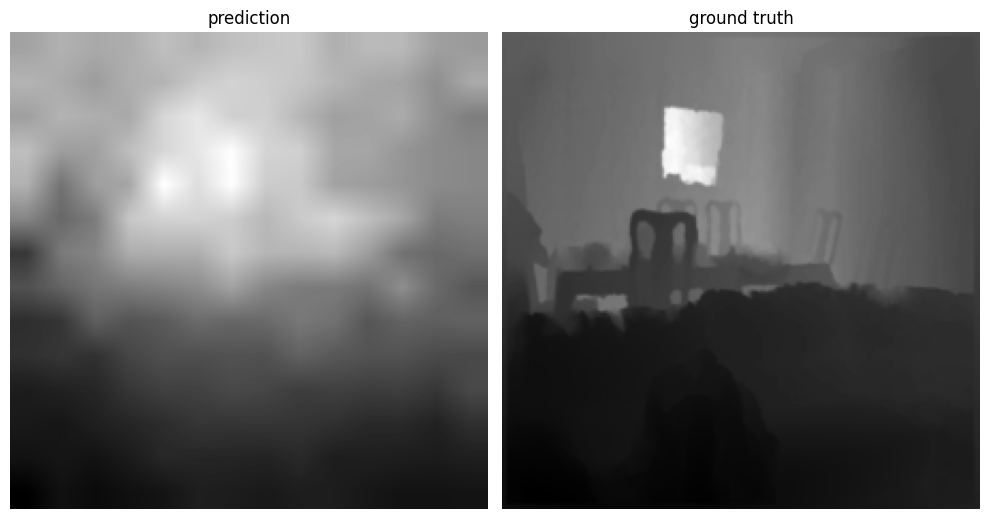

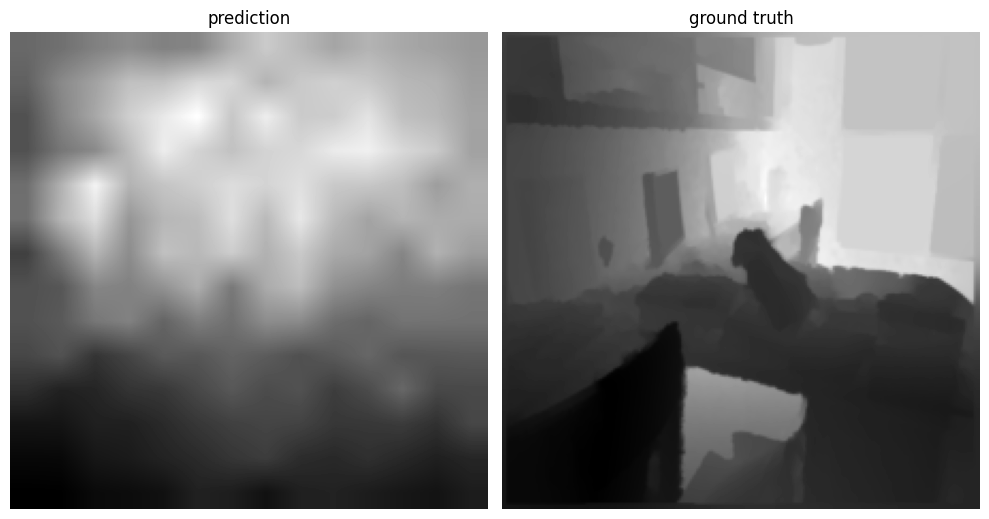

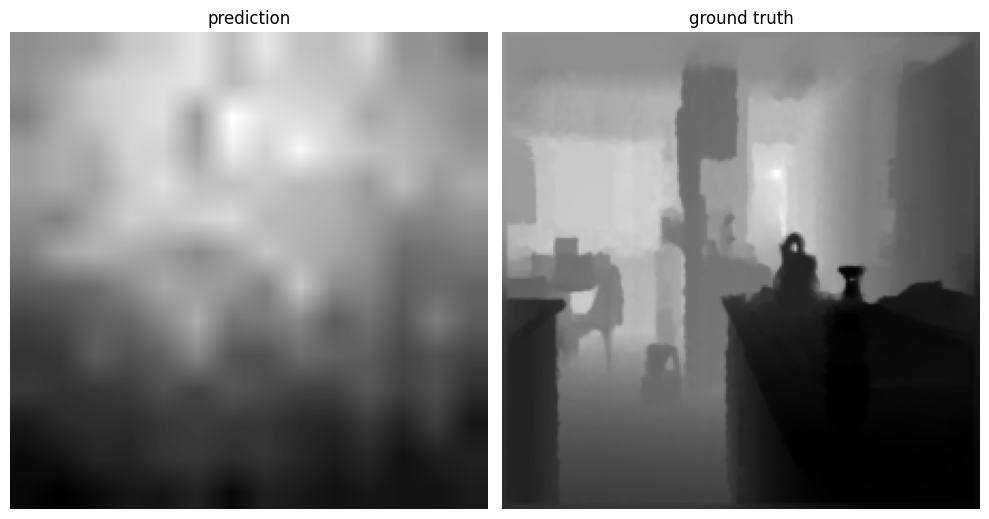

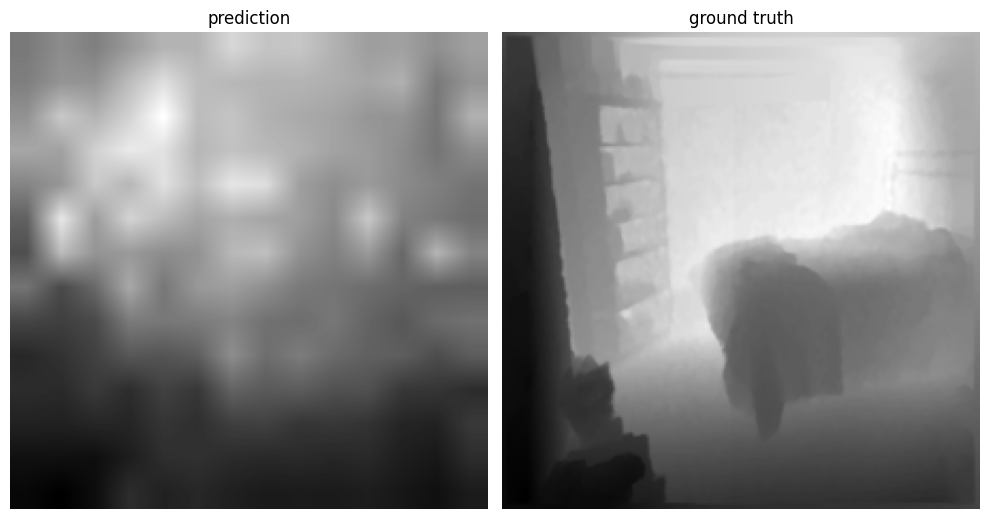

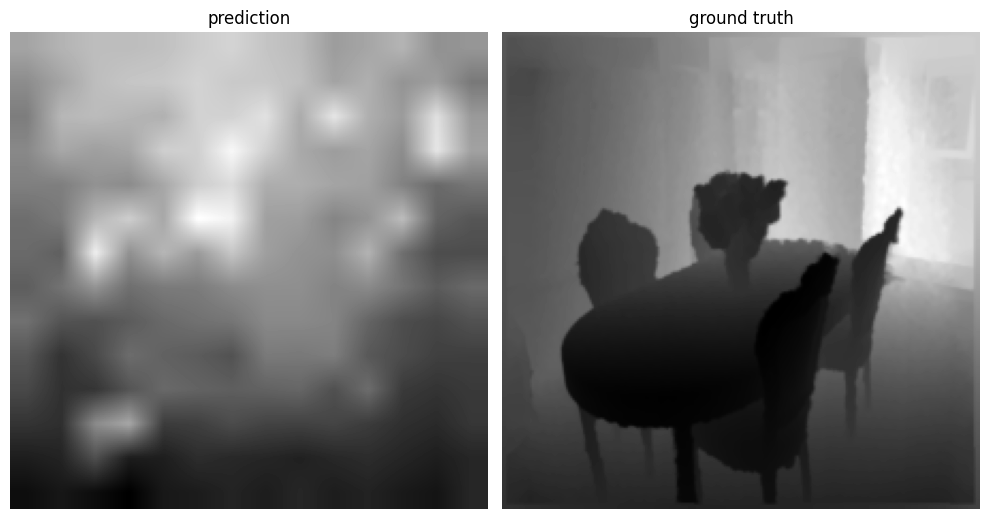

In [114]:
beta = .1

for image, label in subset_loader_test:
    # Process the image and label
    inputs = processor(images=image, return_tensors="pt")
    inputs = inputs.to(device)
    # Extract features using the model
    model.to(device)
    model.eval()
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    #Squeeze the batch dimension out
    last_hidden_states = last_hidden_states.squeeze(0)
    # For ViT, the [CLS] token is at the first position (index 0) in the sequence
    patch_features = last_hidden_states[1:, :]
    #patch features [784 x 768] keys
    patch_features = torch.nn.functional.normalize(patch_features, p=2, dim=-1)
    # Perform the search. This will return the indices of the top-k nearest neighbors.
    neighbors, similarity = searcher.search_batched(patch_features.cpu().detach())

    similarity = (1/beta)*similarity
    similarity = torch.tensor(similarity)
    similarity  = F.softmax(similarity, dim=1)


    neighbor_labels = labels[neighbors]

    weighted_labels = similarity * neighbor_labels.astype(np.float32)
    local_predictions = torch.sum(weighted_labels, dim=1)
    # print(local_predictions.int())
    # print(label[0])

    local_predictions_reshaped = local_predictions.reshape((14,14))
    # print(local_predictions_reshaped)
    # Upsample the downsampled predictions to the original image size
    predictions_image = Image.fromarray(np.array(local_predictions_reshaped))#.astype(np.int16))
    pred = predictions_image.resize((224, 224), Image.BILINEAR)
    pred = np.array(pred)


    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(10, 8))
    # Display images
    axes[0].imshow(pred, cmap='gray')
    axes[0].set_title('prediction')
    axes[0].axis('off')

    axes[1].imshow(label.squeeze(), cmap='gray')
    axes[1].set_title('ground truth')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()